In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [62]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            self.conv_block(1, 64),

        )
        self.decoder = nn.Sequential(

            self.conv_block(64, 1)
        )
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
    
    def forward(self, x):
        #print(x.shape)
        x = self.encoder(x)
        #print(x.shape)
        x = self.decoder(x)
        #print(x.shape)
        return x


In [63]:
def noised_img(image, noise_level=0.15):
    noise = torch.randn_like(image) * noise_level
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0., 1.)
    return noisy_image
def generate_noise_image(size=(28, 28), mean=0.0, std=1.0):
    noise_image = torch.randn(size) * std + mean
    return noise_image

In [64]:
def display_image(tensor, title="Image"):
    image = tensor.squeeze(0).squeeze(0).cpu().detach().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()

In [65]:
def train_dip(noisy_image, clean_image, num_steps=2000, lr=0.00001):
    net = UNet().cuda()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    noisy_image = noisy_image.cuda()
    clean_image = clean_image.cuda()

    for step in range(num_steps):
        optimizer.zero_grad()
        output = net(noisy_image)

        loss = criterion(output, clean_image)
        loss.backward()
        optimizer.step()

        if step % 1000 == 0:
            print(f'Step {step}/{num_steps}, Loss: {loss.item()}')
            display_image(output.cpu().detach(), title=f"Step {step}")

    return net

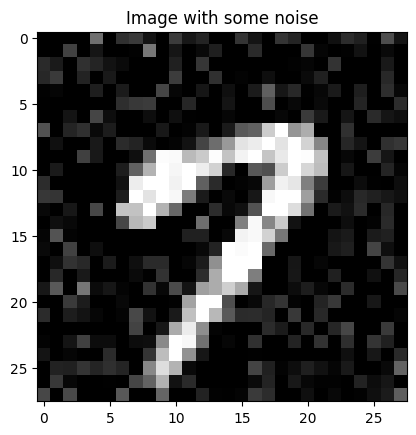

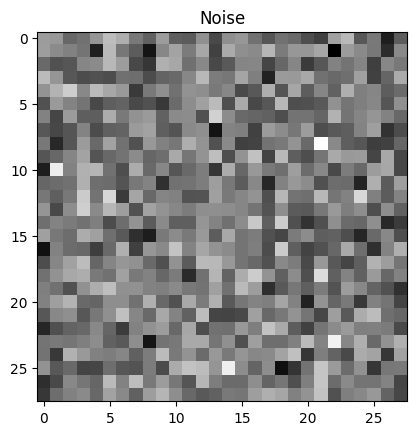

Step 0/2000, Loss: 0.08214861154556274


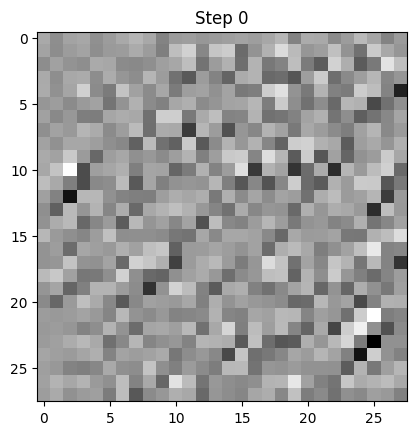

Step 1000/2000, Loss: 0.06102015823125839


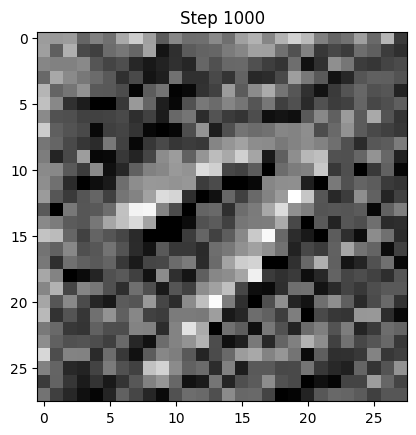

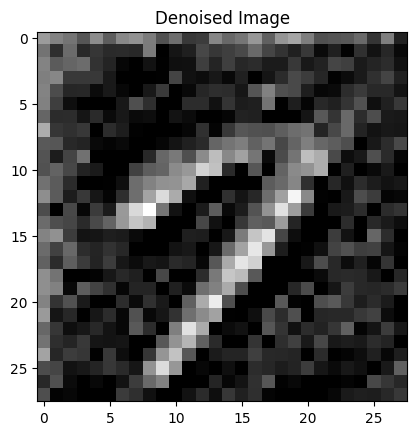

In [66]:
# Load the MNIST dataset
transform = transforms.Compose([
        transforms.ToTensor()
    ])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
noised_image, _ = mnist_dataset[15]  # Use the first image for simplicity
noised_image = noised_image.unsqueeze(0)  # Add batch dimension

noise = generate_noise_image()
noise = noise.reshape((1,1,28,28))
noised_image = noised_img(noised_image)

display_image(noised_image, title="Image with some noise")
display_image(noise, title="Noise")
torch.save(noise , 'input_noise.pt')
net = train_dip(noise, noised_image)
torch.save(net.state_dict() ,'DIP_sample.pth' )
denoised_image = net(noise.cuda()).cpu().detach()

display_image(denoised_image, title="Denoised Image")